## Занятие 8. Поиск ключевых точек и сопоставление изображений
#### Часть 2. Сопоставление с помощью классических алгоритмов CV
## Для работы ноутбука - должен быть установлен OpenCV

In [1]:
! pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.7 MB/s eta 0:00:00


In [2]:
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import numpy as np
plt.rcParams['figure.figsize'] = [10, 20]

## Classic CV matching
**Дано**: изображение запрос(Query), изображение референс(Reference)

**Надо**: найти матрицу проективного отображения, "наилучшим" образом отображающее Q в R

**Алгоритм**:

0. Найти ключевые точки (КТ) на R
1. Найти ключевые КТ на Q
2. Сопоставить КТ Q и R друг-другу
3. На основе сопоставления точек найти гомографию из Q в R


In [3]:
import cv2

def compute_keypoints(img, response_quantile=0.25):
    #0-1. Найти ключевые точки (КТ) на изображении
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp = sift.detect(gray, None)
    # фильтруем 25% неуверенных точек
    
    q_val = np.quantile(list(k.response for k in kp), response_quantile)
    kp = [k for k in kp if k.response > q_val]
        
    kp, features = sift.compute(gray, kp)
    return kp, features 


def match_keypoints(kp_q, ft_q, kp_r, ft_r, ratio=0.75):
    # 2. Сопоставить КТ query и ref друг-другу
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(ft_q, ft_r, k=2)
    good = []

    # Дополнителный опциональный шаг - фильтрация Lowe, Lowe ratio-test:
    # Пусть есть лучший матч1 (query-kp, ref-kp)
    # Если есть другой возможный матч2 (query-kp, ref-kp2), и их качество
    # (т.е. расстояние в пространстве features) маленькое,
    # то нельзя быть уверенном, что матч1 - надежный, и проще его выбросить
    for m,n in matches:
        if m.distance <  ratio * n.distance:
            good.append([m])
            
    ptsA = np.zeros((len(good), 2), dtype="float")
    ptsB = np.zeros((len(good), 2), dtype="float")

    for (i, mlist) in enumerate(good):
        m = mlist[0]
        ptsA[i] = kp_q[m.queryIdx].pt
        ptsB[i] = kp_r[m.trainIdx].pt
    return ptsA, ptsB


def find_projection(points_from, points_to):
    # 3. На основе сопоставления найти гомографию из ref в query
    (H, mask) = cv2.findHomography(points_from, points_to, method=cv2.RANSAC)
    return H

### Про RANSAC
RANdom SAmple Consensus - итеративный алгоритм оценки параметров модели, соответствующих минимальному числу выбросов.

https://en.wikipedia.org/wiki/Random_sample_consensus

Основное отличие от MSE - устойчивость к шуму. 


Пример:
- Имеется константная одномерная модель $y(\theta) = \theta + Noize$
- Дано 10 измерений `y`: [-0.1, 0.5, -0.6, 0.3, 0.1, 0.0, 0.1, -0.2, 0.05, 420]

- Оценка RANSAC: $\theta \approx 0$
- Оценка MSE: $\theta \approx 42 $


In [4]:
img1 = plt.imread(Path() / 'hpatches_tiny'/'v_bird'/'1.ppm')
img2 = plt.imread(Path() / 'hpatches_tiny'/'v_bird'/'2.ppm')
img4 = plt.imread(Path() / 'hpatches_tiny'/'v_bird'/'4.ppm')


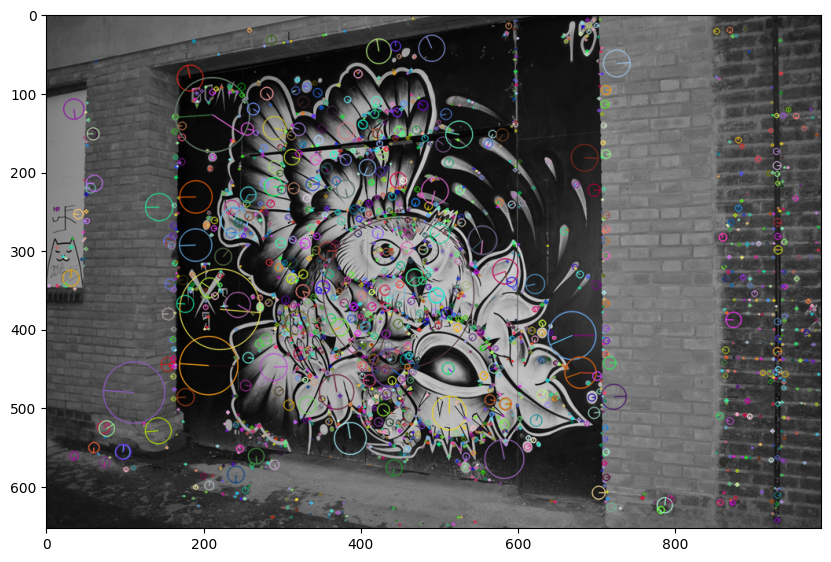

In [5]:
kps2, fts2 = compute_keypoints(img2)

plt.imshow(
    cv2.drawKeypoints(
        cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY),
        kps2,
        img2.copy(),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
)

## Задача-2. Напишите функцию, которая отобразит изображение Query в изображение Reference

In [6]:
def classic_matching_pipeline(img_Q, img_R):
    """
    Находит отображение Query в Reference, применяет его к изображению
    """
    kp_q, ft_q = compute_keypoints(img_Q)
    kp_r, ft_r = compute_keypoints(img_R)
    points_from, points_to = match_keypoints(kp_q, ft_q, kp_r, ft_r)
    H = find_projection(points_from, points_to)
    transformed = cv2.warpPerspective(img_Q, H, dsize=(img_R.shape[1], img_R.shape[0]))
    return transformed


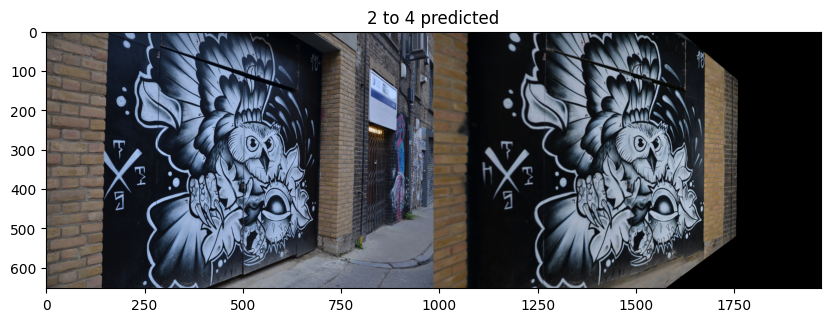

In [7]:
plt.title("2 to 4 predicted")

img_2_to_4 = classic_matching_pipeline(
    img2,
    img4
)

plt.imshow(
    np.concatenate((img4, img_2_to_4), axis=1)
)

Отличный метод, если изображения визуально схожи, и хорошее проективное отображение существует.

Если изображения имеют визуальные различия (цвет, контрастность) - метод ломается.

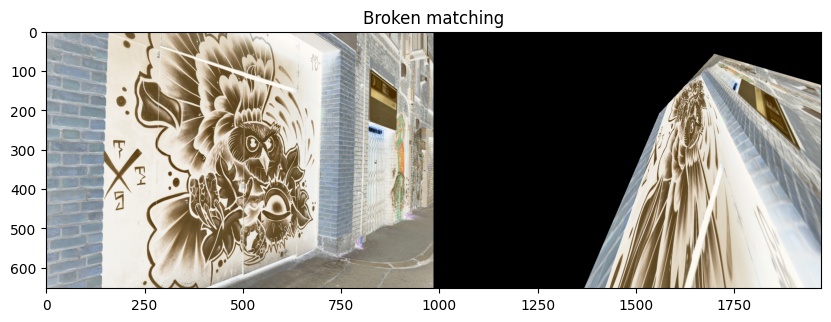

In [8]:
plt.title("Broken matching")
inv_img_match = classic_matching_pipeline(
    255 - img4,
    img4
)
plt.imshow(
    np.concatenate((255 - img4, inv_img_match), axis=1)
)
